In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import json

import statsmodels

import plotly.express as px
import plotly.io as pio
pio.renderers.default='jupyterlab'

# Load Data


## Giffords Gun Law Scorecard

Load the [Giffords Gun Law Scorecard](https://giffords.org/lawcenter/resources/scorecard) for each state. Giffords gun law score have the following scale, from strongest gun laws to weakest: \[A+, A, A-, B+, B, B-, C+, C, C-, D+, D, D-, F\]. 

Note, original Giffords scores have been coerced into a 5-point [Likert scale](https://en.wikipedia.org/wiki/Likert_scale) and a numeric grade was assigned to each letter grade: \[A: 4, B: 3, C: 2, D: 1, F: 0\]. 

In [2]:
scorecard_df = pd.read_csv('giffords_gun_law_scorecard.csv')
scorecard_df.head(n=10)

,state_abbrev,giffords_grade,grade
0,NY,A,4.0
1,NJ,A,4.0
2,MD,A,4.0
3,MA,A,4.0
4,IL,A,4.0
5,HI,A,4.0
6,CT,A,4.0
7,CA,A,4.0
8,WA,B,3.0
9,VA,B,3.0


## Firearm Related Deaths

Load the firearm related mortality data for each state from the [CDC](https://www.cdc.gov/nchs/pressroom/sosmap/firearm_mortality/firearm.htm). Data was acquired using the [Socrata Open Data API](https://dev.socrata.com) and wrangled for this presentation. See DataWrangling.ipynb for details.

In [3]:
firearm_related_deaths_df = pd.read_csv('tidy-489q-934x-firearm-related-injury.csv')
firearm_related_deaths_df.tail(n=10)

,year_and_quarter,state,state_abbrev,mortality_per_100k
540,2022 Q3,South Dakota,SD,16.7
541,2022 Q3,Tennessee,TN,21.6
542,2022 Q3,Texas,TX,16.1
543,2022 Q3,Utah,UT,12.4
544,2022 Q3,Vermont,VT,13.4
545,2022 Q3,Virginia,VA,15.3
546,2022 Q3,Washington,WA,13.0
547,2022 Q3,West Virginia,WV,17.9
548,2022 Q3,Wisconsin,WI,14.5
549,2022 Q3,Wyoming,WY,23.6


Retain only the latest data for firearm related deaths.

In [4]:
deaths_q3_2022 = firearm_related_deaths_df[firearm_related_deaths_df['year_and_quarter'] == '2022 Q3']
deaths_q3_2022.head()

,year_and_quarter,state,state_abbrev,mortality_per_100k
500,2022 Q3,Alabama,AL,25.6
501,2022 Q3,Alaska,AK,23.3
502,2022 Q3,Arizona,AZ,20.9
503,2022 Q3,Arkansas,AR,22.4
504,2022 Q3,California,CA,9.1


Merge firearm related deaths and Giffords scrore datasets.

In [5]:
df = deaths_q3_2022.merge(scorecard_df, on='state_abbrev')
df = df.sort_values(by=['giffords_grade'], ascending=True)
df = df.reset_index(drop=True)
df.head()

,year_and_quarter,state,state_abbrev,mortality_per_100k,giffords_grade,grade
0,2022 Q3,Illinois,IL,14.7,A,4.0
1,2022 Q3,Maryland,MD,13.5,A,4.0
2,2022 Q3,New Jersey,NJ,5.3,A,4.0
3,2022 Q3,Hawaii,HI,4.3,A,4.0
4,2022 Q3,Massachusetts,MA,3.9,A,4.0


# [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) of Firearm Mortality

Load [GeoJSON](https://geojson.org) data that was previously downloaded from [here](https://eric.clst.org/tech/usgeojson/).

In [6]:
us_states = json.load(open('states.geojson', 'r'))

Add a new property 'id' to features - 'id' is the default name of column that is used to map values from the dataset ('state') to the corresponding State in GerJSON data.

In [7]:
for feat in us_states['features']:
    feat['id'] = feat['properties']['NAME']

Display Firearm Mortality by State on map.

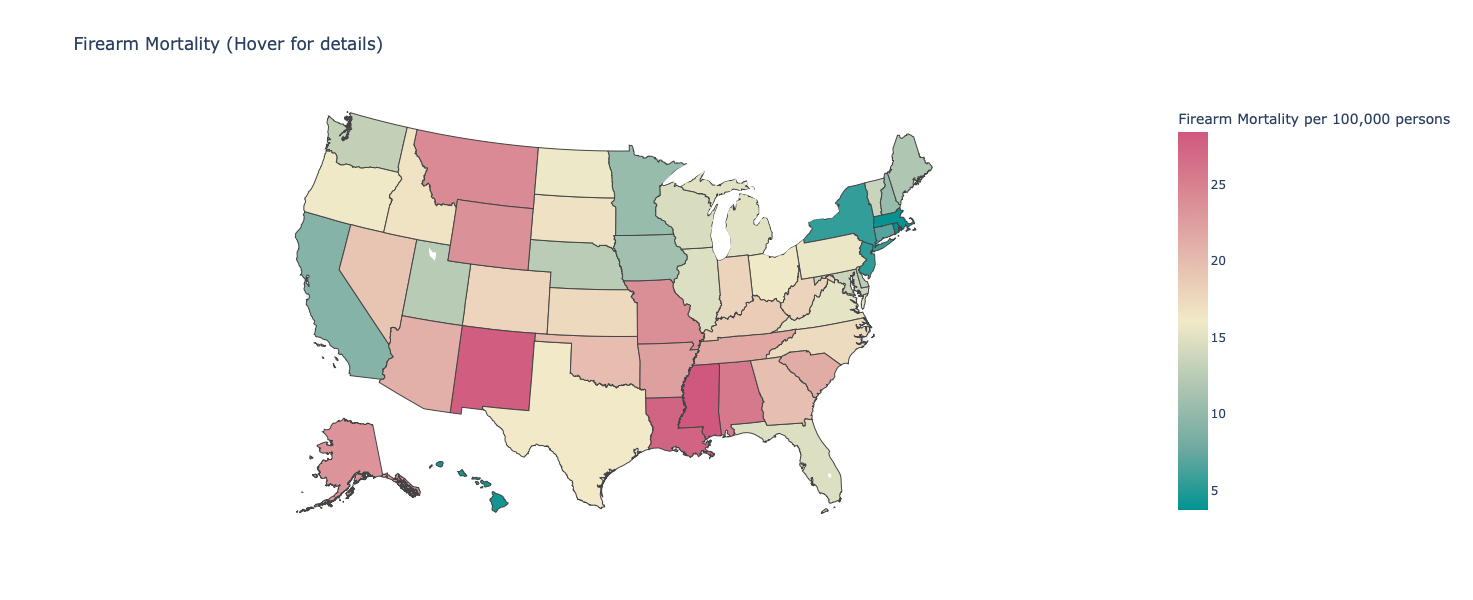

In [8]:
fig = px.choropleth(df, locations='state', scope='usa', geojson=us_states,
                    color='mortality_per_100k', 
                    hover_name='state', 
                    hover_data=['giffords_grade'],
                    color_continuous_scale='Tealrose',
                    color_continuous_midpoint=np.average(df['mortality_per_100k']),                
                    labels={
                     "mortality_per_100k": "Firearm Mortality per 100,000 persons",
                     "giffords_grade" : "Giffords Gun Law Scorecard",
                     "state" : "State"
                    },
                    height=600,
                    width=1100,
                    title='Firearm Mortality (Hover for details)')


fig.show()

# Heatmap (Treemap) of Firearm Mortality grouped by Giffords Gun Law Scorecard

The Heatmap makes revels the following trends:

- States with the strictest gun laws have the lowest firearm related mortality rates
- There are a few outliers: e.g. New Mexico, which has extremely high firearm related mortality despite a non-failing gun law score. Utah, Maine, Iowa, and New Hampshire are other outliers. Explaining outliers is not in scope for this presentation 

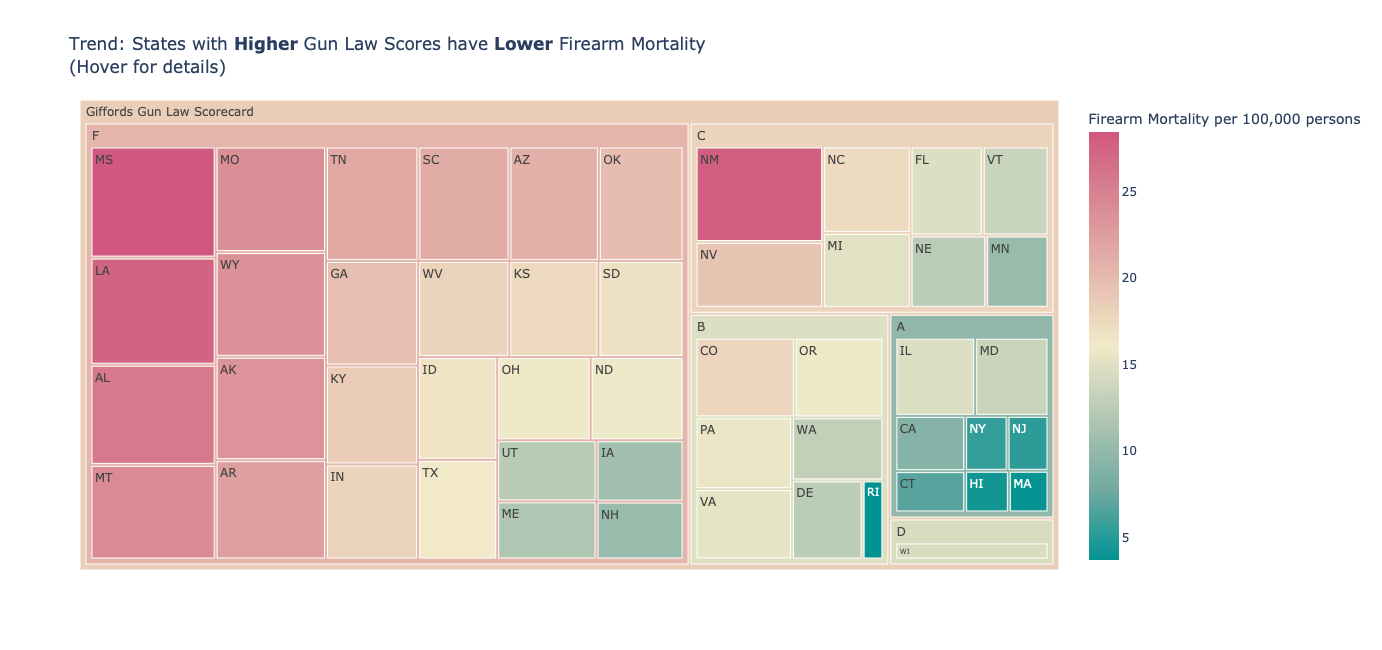

In [46]:
import plotly.graph_objects as go
fig = px.treemap(df, path=[px.Constant('Giffords Gun Law Scorecard'), 'giffords_grade', 'state_abbrev'], values='mortality_per_100k',
                  color='mortality_per_100k', 
                 labels={"mortality_per_100k": "Firearm Mortality per 100,000 persons"},
                 height=650,
                 width=1100,
                 title='Trend: States with <b>Higher</b> Gun Law Scores have <b>Lower</b> Firearm Mortality<br>(Hover for details)</br>',
                 hover_name='state',
                 hover_data=['mortality_per_100k'],
                 color_continuous_scale='Tealrose',
                 color_continuous_midpoint=np.average(df['mortality_per_100k'])              
                )
fig.show()

# Scatterplot with trend line using [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares)

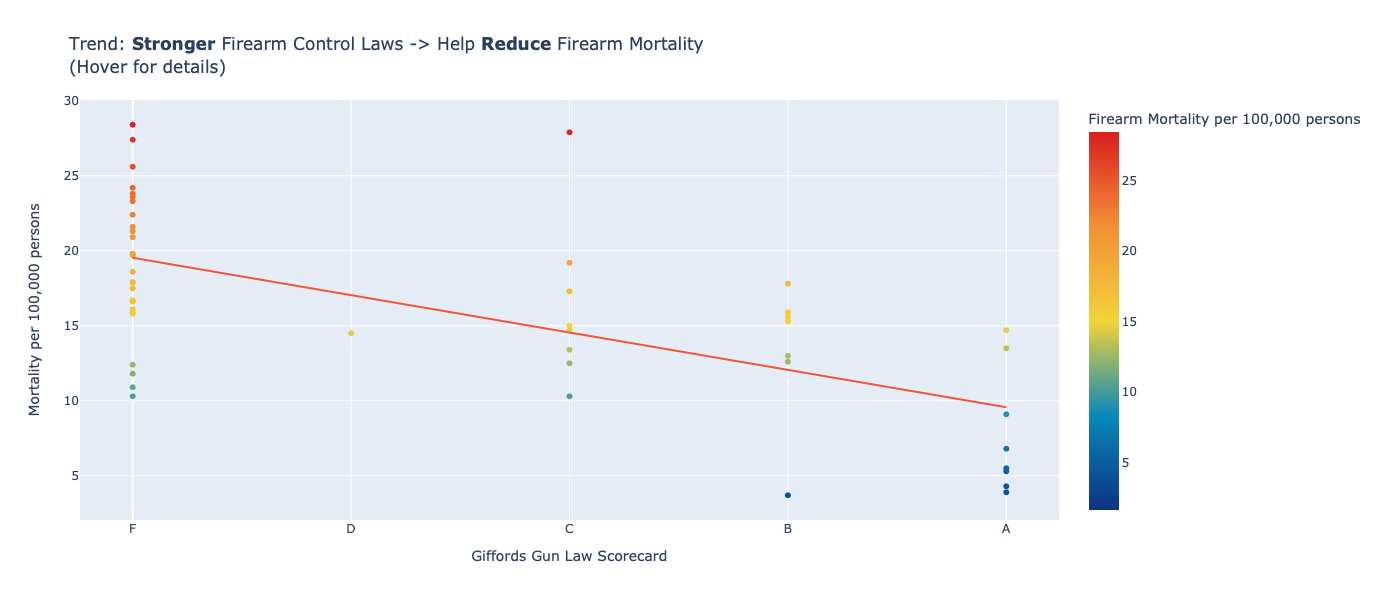

In [47]:
fig = px.scatter(df, x="grade", y="mortality_per_100k",
                 color="mortality_per_100k", 
                 labels={
                     "mortality_per_100k": "Firearm Mortality per 100,000 persons",
                     "state" : "State",
                     "grade" : 'Giffords Gun Law Scorecard'
                 },
                 height=600,
                 width=1100,
                 hover_name='state', 
                 hover_data=['giffords_grade', 'mortality_per_100k'], 

                 color_continuous_scale=px.colors.diverging.Portland,
                 color_continuous_midpoint=15,
                 
                 trendline='ols',
                 title='Trend: <b>Stronger</b> Firearm Control Laws -> Help <b>Reduce</b> Firearm Mortality<br>(Hover for details)</br>'
            )

fig.update_xaxes(tickmode='array', tickvals=df['grade'], ticktext=df['giffords_grade'])
fig.update_layout(
          xaxis_title='Giffords Gun Law Scorecard',
          yaxis_title="Mortality per 100,000 persons"
)
#fig.update_traces(visible=False, selector=dict(mode="markers"))
fig.show()